In [1]:
import pandas as pd
import numpy as np


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
data_ts_1 = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds main data.csv")


In [3]:
data_ts_2 = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds main data 2.csv")

In [4]:
data_ts_2.head()

,Bond name,Dates,10/29/21,11/30/21,12/31/21,1/31/22,2/28/22,3/31/22,4/29/22,5/31/22,...,1/31/24,2/29/24,3/29/24,4/30/24,5/31/24,6/28/24,7/31/24,8/30/24,9/30/24,10/31/24
0,YT265569 Corp,PX_ASK,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,PX_BID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,YLD_YTM_BID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,YLD_YTM_ASK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YT424075 Corp,PX_ASK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data_ts_1.rename(columns={data_ts_1.columns[0]:"Bloomberg Ticker"}, inplace=True)
data_ts_1.rename(columns={data_ts_1.columns[1]:"Variable"}, inplace= True)

In [6]:
data_ts_2.rename(columns={data_ts_2.columns[1]:"Variable"}, inplace = True)
data_ts_2.rename(columns={data_ts_2.columns[0]:"Bloomberg Ticker"}, inplace=True)

In [7]:
data_ts_1 = data_ts_1.iloc[:,:-1]

In [8]:
data_ts_1['Bloomberg Ticker'] = data_ts_1['Bloomberg Ticker'].ffill()
data_ts_2['Bloomberg Ticker'] = data_ts_2['Bloomberg Ticker'].ffill()

In [9]:
data_ts_1_long = pd.melt(data_ts_1, id_vars=["Bloomberg Ticker","Variable"], value_vars=data_ts_1.columns[2:], var_name="Date", value_name='Value')

In [10]:
data_ts_2_long = pd.melt(data_ts_2, id_vars=["Bloomberg Ticker", "Variable"], value_vars=data_ts_2.columns[2:], var_name="Date", value_name="Value")

In [11]:
merged_data = pd.merge(data_ts_1_long, data_ts_2_long, on=['Bloomberg Ticker', 'Variable', 'Date'], how='left', suffixes=('_main','_subset'))

In [12]:
merged_data.head()

,Bloomberg Ticker,Variable,Date,Value_main,Value_subset
0,YT186506 Corp,PX_ASK,10/29/21,NaN,NaN
1,YT186506 Corp,PX_BID,10/29/21,NaN,NaN
2,YT186506 Corp,YLD_YTM_BID,10/29/21,NaN,NaN
3,YT186506 Corp,YLD_YTM_ASK,10/29/21,NaN,NaN
4,YT265328 Corp,PX_ASK,10/29/21,NaN,NaN


In [13]:
merged_data['Value_main'].replace('#N/A Review',np.nan, inplace=True)
merged_data['Value_main'].replace('#NAME?',np.nan, inplace=True)
merged_data['Value_subset'].replace(' ',np.nan, inplace=True)

merged_data['Value_main'] = merged_data['Value_main'].astype(float)
merged_data['Value_subset'] = merged_data['Value_subset'].astype(float)


#print(merged_data.dtypes)

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_1182/2448527503.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['Value_main'].replace('#N/A Review',np.nan, inplace=True)
/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_1182/2448527503.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

In [14]:
merged_data['Combined'] = merged_data['Value_main'].combine_first(merged_data['Value_subset'])

In [15]:
merged_data['Date'] = pd.to_datetime(merged_data['Date'], format = '%m/%d/%y', errors='coerce')

In [16]:
merged_data['Date_M_Y'] = merged_data['Date'].dt.to_period('M')

In [17]:
merged_data.sort_values(by=['Bloomberg Ticker','Variable', 'Date'], inplace=True)

In [18]:
merged_data.drop_duplicates(subset=['Bloomberg Ticker', 'Variable', 'Combined'], inplace=True)

In [19]:
indices_to_drop = merged_data[merged_data['Bloomberg Ticker'] == '2284'].index
print(indices_to_drop)

merged_data.drop(index=indices_to_drop, inplace = True)

Index([11996, 11994, 11993, 11995, 11992, 11991], dtype='int64')


In [20]:
pivot = merged_data.pivot_table(index=['Bloomberg Ticker', 'Date'], columns='Variable', values="Combined", aggfunc='first').reset_index()

In [21]:
pivot['Date'] = pivot['Date'].dt.to_period('M')

In [22]:
#Adding a column which will classify the security
pivot['Classification'] = 'Corporate Green Bond'

In [23]:
pivot.index = pivot['Date']

Import second time series dataset. Macroeconomic and stock market variables.

In [24]:
data_ts_3 = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/Time series second phase cleaned & merged.csv")

In [25]:
data_ts_3.head()

,Description,10/29/21,11/30/21,12/31/21,1/31/22,2/28/22,3/31/22,4/29/22,5/31/22,6/30/22,...,1/31/24,2/29/24,3/29/24,4/30/24,5/31/24,6/28/24,7/31/24,8/30/24,9/30/24,10/31/24
0,S&P500 VOLATILITY INDEX,16.26,27.19,17.22,24.83,30.15,20.56,33.40,26.19,28.71,...,14.35,13.40,13.01,15.65,12.92,12.44,16.36,15.00,16.73,23.16
1,S&P500 PX_LAST,4605.38,4567.00,4766.18,4515.55,4373.94,4530.41,4131.93,4132.15,3785.38,...,4845.65,5096.27,5254.35,5035.69,5277.51,5460.48,5522.30,5648.40,5762.48,5705.45
2,S&P500 PX_BID,4561.03,4528.64,4701.56,4459.92,4299.02,4499.97,4108.68,4094.66,3733.31,...,4814.01,5042.80,5200.84,4970.00,5224.07,5426.23,5484.77,5571.95,5700.44,5669.85
3,S&P500 PX_ASK,4677.16,4647.79,4834.94,4568.93,4419.26,4587.05,5434.72,4178.75,3819.46,...,4895.08,5160.48,5309.45,5075.58,5328.88,5513.21,5595.24,5713.68,5803.09,5764.36
4,EURO STOXX 50,4250.56,4063.06,4298.41,4174.60,3924.23,3902.52,3802.86,3789.21,3454.86,...,4648.40,4877.77,5083.42,4921.22,4983.67,4894.02,4872.94,4957.98,5000.45,4827.63


In [26]:
data_ts_3_pivot = data_ts_3.T

In [27]:
data_ts_3_pivot.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
Description,S&P500 VOLATILITY INDEX,S&P500 PX_LAST,S&P500 PX_BID,S&P500 PX_ASK,EURO STOXX 50,STOXX EUROPE 600,EURO STOXX 50 VOLATILITY,EUROPEAN RENEWABLE ENERGY INDEX,US IMPLIED YIELD VOLATILITY INDEX,GOLD IN EUR PX_LAST,...,EUROZONE 7-YEAR BOND YTM_ASK,EUROZONE 5-YEAR BOND YTM_BID,EUROZONE 5-YEAR BOND YTM_ASK,EUROZONE 3-YEAR BOND YTM_BID,EUROZONE 3-YEAR BOND YTM_ASK,EUROZONE 2-YEAR BOND YTM_BID,EUROZONE 2-YEAR BOND YTM_ASK,NASDAQ CLEAN EDGE GREEN ENERGY,MSCI EUROPE SELECT GREEN 50 5% DECREMENT NET I...,BLOOMBERG ECONOMIC SURPRISE INDEX - EUROZONE
10/29/21,16.26,4605.38,4561.03,4677.16,4250.56,475.51,17.6164,2458.32,75.45,1542.54,...,-0.264,-0.39,-0.394,-0.542,-0.553,-0.585,-0.597,1012.5,1864.62,105.61
11/30/21,27.19,4567.0,4528.64,4647.79,4063.06,462.96,30.0679,2294.14,84.04,1565.07,...,-0.519,-0.618,-0.627,-0.744,-0.759,-0.737,-0.756,1008.21,1808.27,100.34
12/31/21,17.22,4766.18,4701.56,4834.94,4298.41,487.8,19.2677,2216.63,77.1,1608.82,...,-0.366,-0.453,-0.469,-0.641,-0.67,-0.62,-0.651,889.43,1880.8,106.93
1/31/22,24.83,4515.55,4459.92,4568.93,4174.6,468.88,27.0084,1970.35,85.14,1599.48,...,-0.179,-0.22,-0.234,-0.426,-0.436,-0.528,-0.544,748.43,1734.29,100.96


In [28]:
data_ts_3_pivot.columns = data_ts_3_pivot.iloc[0]

In [29]:
data_ts_3_pivot = data_ts_3_pivot.drop(index='Description')

In [30]:
data_ts_3_pivot.index = pd.to_datetime(data_ts_3_pivot.index, format='%m/%d/%y')
data_ts_3_pivot.index = data_ts_3_pivot.index.to_period('M')

In [31]:
data_ts_3_pivot.index.name = 'Date'

Merging the two datasets


In [32]:
pivot = pivot.drop(columns='Date')

In [33]:
final_1 = pd.merge(pivot, data_ts_3_pivot, how='outer', on='Date')

In [34]:
final_1.rename(columns={final_1.columns[0]:'Ticker'}, inplace=True)

Static data import and merge

In [35]:
static_1 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 2.csv')

In [36]:
static_1.rename(columns={static_1.columns[0]:'Ticker'}, inplace=True)

In [37]:
static_2 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 3.csv')

In [38]:
static_2.rename(columns={static_2.columns[7]:'Ticker'}, inplace=True)

In [39]:
static_3 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 4.csv')

In [40]:
static_3.rename(columns={static_3.columns[11]:'Ticker'}, inplace=True)

In [41]:
static_4 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 5_use of proceeds.csv')

In [42]:
static_4.rename(columns={static_4.columns[1]:'Ticker'}, inplace= True)

In [43]:
final_1['Date'] = final_1.index

In [44]:
final_2 = pd.merge(final_1, static_1,  how='outer', on='Ticker')

In [45]:
final_2 = pd.merge(final_2, static_2,  how='outer', on='Ticker')

In [46]:
final_2 = pd.merge(final_2, static_3,  how='outer', on='Ticker')

In [47]:
final_2 = pd.merge(final_2, static_4,  how='outer', on='Ticker')

In [48]:
final_2.replace('#N/A Field Not Applicable', np.nan, inplace=True)

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_1182/1454516632.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_2.replace('#N/A Field Not Applicable', np.nan, inplace=True)


In [49]:
final_2.index = final_2['Date']

In [50]:
final_2 = final_2.drop(columns='Date')

Analysing of dataset

In [51]:
pd.set_option('display.max_rows', None)
#print(final_2.dtypes)

In [52]:
#print(type(final_2))

In [53]:
pd.set_option('display.max_rows', None)
#print(final_2.dtypes)

In [54]:

def convert_columns(final_2, max_unique_ratio=0.1, max_unique_count=20):
    for col in final_2.columns:
        print(f"Processing column: {col}")

        # Step 1: Handle numeric conversion more robustly
        try:
            # First try converting to numeric, preserving original type if possible
            numeric_series = pd.to_numeric(final_2[col], errors='coerce')
            
            # Check if conversion was meaningful
            if not numeric_series.isna().all():
                # Prefer integer if no decimal loss
                if np.allclose(numeric_series, numeric_series.astype(int), rtol=1e-5, atol=1e-8):
                    final_2[col] = numeric_series.astype(int)
                    print(f"Column {col} converted to integer")
                else:
                    final_2[col] = numeric_series.astype(float)
                    print(f"Column {col} converted to float")
                continue
        except Exception as e:
            print(f"Detailed error converting column {col} to numeric: {e}")

        # Step 2: Handle categorical columns more carefully
        if final_2[col].dtype == 'object':
            unique_count = final_2[col].nunique()
            total_count = len(final_2[col])
            
            # Multiple checks for categorical
            if (unique_count / total_count < max_unique_ratio) or \
               (0 < unique_count <= max_unique_count):
                final_2[col] = final_2[col].astype('category')
                print(f"Column {col} converted to category")

    return final_2

In [55]:
final_2 = convert_columns(final_2)
#print(final_2.dtypes)

Processing column: Ticker
Column Ticker converted to category
Processing column: PX_ASK
Detailed error converting column PX_ASK to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: PX_BID
Detailed error converting column PX_BID to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: YLD_YTM_ASK
Detailed error converting column YLD_YTM_ASK to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: YLD_YTM_BID
Detailed error converting column YLD_YTM_BID to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: Classification
Column Classification converted to category
Processing column: S&P500 VOLATILITY INDEX
Detailed error converting column S&P500 VOLATILITY INDEX to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: S&P500 PX_LAST
Detailed error converting column S&P500 PX_LAST to numeric: Cannot convert non-finite values (NA or in

In [56]:
final_2['Issue Price'] = final_2['Issue Price'].astype(float)
final_2['Issue Date'] = pd.to_datetime(final_2['Issue Date'],format='%m/%d/%Y', errors='coerce')

In [57]:
final_2 = final_2.copy()

final_2['Issue Price'] = final_2['Issue Price'].astype(float)
final_2['Issue Date'] = pd.to_datetime(final_2['Issue Date'], format='%m/%d/%Y', errors='coerce')

In [58]:
#print(final_2.dtypes)

In [59]:
final_2.reset_index(inplace=True)
final_3 = final_2.dropna(subset=['Date','YLD_YTM_ASK'], how='all', inplace=False)


In [60]:
#drop entries where all four variables are missing
final_3 = final_3.dropna(subset=['YLD_YTM_ASK','YLD_YTM_BID','PX_ASK','PX_BID'], how='all')

In [61]:
# Count rows where exactly 4 specified columns have NaN values
count = final_3[['YLD_YTM_ASK', 'YLD_YTM_BID', 'PX_ASK', 'PX_BID']].isna().sum(axis=1).eq(4).sum()
print(count)

0


In [62]:
#print(final_2.isnull().sum())

In [63]:
#dropping variable 'series'


In [64]:
#Extraction of date components
final_3['year'] = final_3['Date'].dt.year
final_3['month'] = final_3['Date'].dt.month
final_3['quarter'] = final_3['Date'].dt.quarter


In [65]:
# Accounting for cyclicality of months (allowing proximity of month 12 to month 1 to be observed)
final_3['month_sin'] = np.sin(2 * np.pi * final_3['month'] / 12)
final_3['month_cos'] = np.cos(2 * np.pi * final_3['month'] / 12)

Encoding of string variables


In [66]:
final_2.to_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/final_2.csv', index=True)

In [67]:
cpn_freq = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/ISIN_CPN_FREQ_BBG.csv")

In [68]:
#print(cpn_freq.dtypes)
#print(final_2.dtypes)

#cpn_freq['Ticker'] = cpn_freq["Ticker"].astype('category')

In [69]:
#print(final_2['Ticker'].cat.categories)
#print(cpn_freq['Ticker'].cat.categories)

In [70]:
final_merge = pd.merge(final_2, cpn_freq, on=["Ticker"])

In [71]:
# An easier way to drop the missing value rows
final_merge = final_merge.dropna(subset=['Ticker', 'Date'])

In [72]:
# Bit more complex way to drop the missing value rows
to_drop = final_merge[(final_merge['Ticker']==' ') | (final_merge['Date']==' ')]
final_merge =final_merge.drop(to_drop.index)

In [73]:
print(final_merge.dtypes)

Date                                                             period[M]
Ticker                                                              object
PX_ASK                                                             float64
PX_BID                                                             float64
YLD_YTM_ASK                                                        float64
YLD_YTM_BID                                                        float64
Classification                                                    category
S&P500 VOLATILITY INDEX                                            float64
S&P500 PX_LAST                                                     float64
S&P500 PX_BID                                                      float64
S&P500 PX_ASK                                                      float64
EURO STOXX 50                                                      float64
STOXX EUROPE 600                                                   float64
EURO STOXX 50 VOLATILITY 

In [74]:
#Convert dates into constant format
final_merge['Maturity'] = pd.to_datetime(final_merge['Maturity'])
#final_merge['Maturity'] = pd.to_datetime(final_merge['Maturity'], format = '%m/%d/%Y').dt.strftime('%d/%m/%Y')
#final_merge['Maturity'] = pd.to_datetime(final_merge['Maturity'], format='%d/%m/%Y')
final_merge['Date'] = final_merge['Date'].dt.to_timestamp('M')

In [75]:
# Calculating mid price 
final_merge['Mid_PX'] = (((final_merge['PX_ASK']+final_merge['PX_BID'])/2))


In [76]:
#back calculating the coupon dates
coupon_1 = ['ISIN','Ticker','Maturity','Issue Date','Cpn','Date','CPN_FREQ','Par Amount']
coupon_dates = final_merge[coupon_1]

In [77]:
coupon_dates['Accrual period'] = (360/(coupon_dates['CPN_FREQ']))
coupon_dates['period_coupon'] =  ((coupon_dates['Cpn'])/coupon_dates['CPN_FREQ'])
coupon_dates['period_months'] = 12/ coupon_dates['CPN_FREQ']
#((coupon_dates['Cpn'])/(coupon_dates['CPN_FREQ']))*100

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_1182/849711941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coupon_dates['Accrual period'] = (360/(coupon_dates['CPN_FREQ']))
/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_1182/849711941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coupon_dates['period_coupon'] =  ((coupon_dates['Cpn'])/coupon_dates['CPN_FREQ'])
/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_1182/849711941.py:3: SettingWithCopyWarning: 
A value

In [78]:
df = coupon_dates.copy()

from pandas.api.types import is_period_dtype, is_datetime64_any_dtype

# 1) Core dtypes
df['Maturity']   = pd.to_datetime(df['Maturity'], errors='coerce')
df['Issue Date'] = pd.to_datetime(df['Issue Date'], errors='coerce')
df['CPN_FREQ']   = pd.to_numeric(df['CPN_FREQ'], errors='coerce').astype('Int64')
df['Cpn']        = pd.to_numeric(df['Cpn'], errors='coerce')

# 2) Normalize Date to month-end Timestamp without ever passing Period to to_datetime
if is_period_dtype(df['Date']):
    # Already Period[M] -> convert to month-end timestamps
    df['Date'] = df['Date'].dt.to_timestamp('M')
elif is_datetime64_any_dtype(df['Date']):
    # Already datetime -> push to month-end
    df['Date'] = df['Date'] + pd.offsets.MonthEnd(0)
else:
    # Likely strings like '2021-10' -> parse, then month-end
    # (If your strings are strictly YYYY-MM, the format speeds parsing)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%Y-%m', exact=False)
    df['Date'] = df['Date'] + pd.offsets.MonthEnd(0)

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_1182/2168478596.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(df['Date']):


In [79]:
# building last/next coupon dates per row
def last_next_coupon_from_maturity(maturity, freq, valuation_date):
    """
    Build schedule backward from maturity stepping 12/f months.
    Return (last_coupon_date, next_coupon_date) around valuation_date.
    """
    if pd.isna(freq) or freq not in (1, 2, 4):
        return (pd.NaT, pd.NaT)

    period_months = int(12 // int(freq))
    schedule = []
    d = maturity
    cutoff = valuation_date - pd.DateOffset(years=30)  # far enough back

    while d > cutoff:
        schedule.append(d)
        d = d - pd.DateOffset(months=period_months)

    schedule.sort()
    if not schedule:
        return (pd.NaT, pd.NaT)

    # last <= valuation_date
    last_cpn = None
    for dt in schedule:
        if dt <= valuation_date:
            last_cpn = dt
        else:
            break

    # next > valuation_date
    next_cpn = next((dt for dt in schedule if dt > valuation_date), pd.NaT)
    if last_cpn is None:
        # valuation before first generated coupon -> treat first as next, no last
        first = schedule[0]
        return (pd.NaT, first)

    return (last_cpn, next_cpn)

In [80]:
#applying the previously generated code
out = df.apply(
    lambda r: pd.Series(
        last_next_coupon_from_maturity(
            r['Maturity'],
            int(r['CPN_FREQ']) if pd.notna(r['CPN_FREQ']) else None,
            r['Date']
        ),
        index=['LastCouponDate', 'NextCouponDate']
    ),
    axis=1
)

df = pd.concat([df, out], axis=1)

In [81]:
#Accrual fraction
days_since_last = (df['Date'] - df['LastCouponDate']).dt.days
days_in_period  = (df['NextCouponDate'] - df['LastCouponDate']).dt.days
df['accrual_frac_act'] = (days_since_last / days_in_period).clip(lower=0, upper=1)

In [82]:
#Approximation of accrual fraction based on 30/360 timeframe
df['accrual_frac_30360'] = (
    (df['Date'] - df['LastCouponDate']).dt.days / (360 / df['CPN_FREQ'])
).clip(lower=0)

In [83]:
# What exactly is happening here??
df['accrual_frac'] = df['accrual_frac_act']

In [84]:
#calculating accrued interest
df['AccruedInterest'] = df['period_coupon'] * df['accrual_frac']
final_merge['period_coupon'] = df['period_coupon']
final_merge['AccruedInterest'] = df['AccruedInterest']

In [85]:
#merging newly calculated data
# keys to join on (adjust to your ID columns)
keys = ['ISIN', 'Ticker', 'Date']  # e.g., ['ISIN', 'Date']

# pick only columns in df that are not already in final_merge (exclude keys)
new_cols = [c for c in df.columns if c not in final_merge.columns and c not in keys]

# if there are no new columns, nothing to do
if new_cols:
    df_sub = df[keys + new_cols].drop_duplicates(subset=keys)
    final_merge = final_merge.merge(df_sub, on=keys, how='left')


In [86]:
#### Debugging last coupon
df['Maturity'] = pd.to_datetime(df['Maturity'], errors='coerce')
# if your Date is 'YYYY-MM', convert to month-end Timestamps
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%Y-%m')
df['Date'] = df['Date'] + pd.offsets.MonthEnd(0)

df['CPN_FREQ'] = pd.to_numeric(df['CPN_FREQ'], errors='coerce').astype('Int64')
df['Cpn']      = pd.to_numeric(df['Cpn'], errors='coerce')

In [87]:
def build_schedule_from_maturity(maturity: pd.Timestamp, freq: int, back_years: int = 40) -> pd.DatetimeIndex:
    if pd.isna(maturity) or pd.isna(freq) or freq not in (1, 2, 4):
        return pd.DatetimeIndex([])
    months = int(12 // int(freq))
    dates = []
    d = maturity
    cutoff = maturity - pd.DateOffset(years=back_years)
    while d >= cutoff:
        dates.append(d)
        d = d - pd.DateOffset(months=months)
    return pd.DatetimeIndex(sorted(dates))

In [88]:
schedules = {}
for isin, g in df.groupby('ISIN', sort=False):
    m = g['Maturity'].iloc[0]
    f = g['CPN_FREQ'].iloc[0]
    schedules[isin] = build_schedule_from_maturity(m, int(f) if pd.notna(f) else None)

In [89]:
def last_next_from_schedule(schedule: pd.DatetimeIndex, valuation: pd.Timestamp):
    if len(schedule) == 0 or pd.isna(valuation):
        return pd.NaT, pd.NaT
    # insertion point *after* valuation
    i = schedule.searchsorted(valuation, side='right')
    last_d = schedule[i-1] if i > 0 else pd.NaT
    next_d = schedule[i]   if i < len(schedule) else pd.NaT
    return last_d, next_d

In [90]:
out = df.apply(
    lambda r: pd.Series(
        last_next_from_schedule(schedules.get(r['ISIN'], pd.DatetimeIndex([])), r['Date']),
        index=['LastCouponDate','NextCouponDate']
    ),
    axis=1
)
df = pd.concat([df, out], axis=1)

In [91]:
# pick one ISIN and inspect
check = df.loc[df['ISIN'].eq(df['ISIN'].iloc[100]), ['Date','LastCouponDate','NextCouponDate']].sort_values('Date').head(12)
print(check)

         Date LastCouponDate LastCouponDate NextCouponDate NextCouponDate
75 2021-10-31     2021-07-17     2021-07-17     2022-01-17     2022-01-17
76 2021-11-30     2021-07-17     2021-07-17     2022-01-17     2022-01-17
77 2021-12-31     2021-07-17     2021-07-17     2022-01-17     2022-01-17
78 2022-01-31     2022-01-17     2022-01-17     2022-07-17     2022-07-17
79 2022-02-28     2022-01-17     2022-01-17     2022-07-17     2022-07-17
80 2022-03-31     2022-01-17     2022-01-17     2022-07-17     2022-07-17
81 2022-04-30     2022-01-17     2022-01-17     2022-07-17     2022-07-17
82 2022-05-31     2022-01-17     2022-01-17     2022-07-17     2022-07-17
83 2022-06-30     2022-01-17     2022-01-17     2022-07-17     2022-07-17
84 2022-07-31     2022-07-17     2022-07-17     2023-01-17     2023-01-17
85 2022-08-31     2022-07-17     2022-07-17     2023-01-17     2023-01-17
86 2022-09-30     2022-07-17     2022-07-17     2023-01-17     2023-01-17


In [92]:
df = df.iloc[:,:-2]

In [93]:
'''# ACT/ACT-style fraction

days_since = (df['Date'] - df['LastCouponDate']).dt.days
days_tot  = (df['NextCouponDate'] - df['LastCouponDate']).dt.days
df['accrual_frac'] = (days_since / days_tot).clip(lower=0, upper=1)

df['period_coupon'] = (df['Cpn'] / df['CPN_FREQ']) * 100
df['AI']            = df['period_coupon'] * df['accrual_frac']

# If you want dirty prices: df['dirty_mid'] = df['clean_mid'] + df['AI']
# If you stick to clean: add coupon cash only in coupon months
df['is_coupon_month'] = df['Date'].eq(df['NextCouponDate'])
df['coupon_cash']     = df['period_coupon'].where(df['is_coupon_month'], 0.0)'''

"# ACT/ACT-style fraction\n\ndays_since = (df['Date'] - df['LastCouponDate']).dt.days\ndays_tot  = (df['NextCouponDate'] - df['LastCouponDate']).dt.days\ndf['accrual_frac'] = (days_since / days_tot).clip(lower=0, upper=1)\n\ndf['period_coupon'] = (df['Cpn'] / df['CPN_FREQ']) * 100\ndf['AI']            = df['period_coupon'] * df['accrual_frac']\n\n# If you want dirty prices: df['dirty_mid'] = df['clean_mid'] + df['AI']\n# If you stick to clean: add coupon cash only in coupon months\ndf['is_coupon_month'] = df['Date'].eq(df['NextCouponDate'])\ndf['coupon_cash']     = df['period_coupon'].where(df['is_coupon_month'], 0.0)"

In [94]:
#calculating dirty_mid
final_merge['dirty_mid'] = (final_merge['Mid_PX']) + (final_merge['AccruedInterest'])

In [95]:
#Debugging last coupon & next coupon attempt 2
# 1) See what columns got suffixed
[c for c in final_merge.columns if c.endswith(('_x','_y'))]

# 2) Check dtypes before/after merge
df[['ISIN','Date','Maturity','CPN_FREQ']].dtypes
final_merge[['ISIN','Date','Maturity','CPN_FREQ']].dtypes

# 3) Did you merge on the right keys?
# If your last/next were computed per (ISIN, Date), you MUST merge on BOTH.

ISIN                object
Date        datetime64[ns]
Maturity    datetime64[ns]
CPN_FREQ             int64
dtype: object

In [96]:
#Evaluation
view1 = ['Date','Issue Date', 'Maturity', 'LastCouponDate','NextCouponDate', 'PX_ASK', 'PX_BID', 'Mid_PX','dirty_mid']
view2 = final_merge[view1]

In [97]:
final_merge.to_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/final_merge.csv', index=False)

In [98]:
#Calculation of returns
final_merge = final_merge.sort_values(['Ticker','Date'])
final_merge['monthly_return_nom'] = final_merge.groupby('Ticker')['dirty_mid'].diff()
final_merge['monthly_return_pct'] = final_merge.groupby('Ticker')['dirty_mid'].pct_change()

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_1182/1940906622.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  final_merge['monthly_return_pct'] = final_merge.groupby('Ticker')['dirty_mid'].pct_change()


In [99]:
duplicates = final_merge.duplicated(subset=['Ticker','Date']).sum()
print("Duplicate (Ticker,Date) rows:", duplicates)

Duplicate (Ticker,Date) rows: 0


In [100]:
#Activate if interested in quarterly return
#df_encoded['quarterly_return'] = df_encoded.groupby('Ticker')['dirty_mid'].pct_change(periods=3)

In [101]:
'''coupon_dates['Maturity'] = pd.to_datetime(coupon_dates['Maturity'])
coupon_dates['Date'] = pd.to_datetime(coupon_dates['Date']).dt.to_period('M').dt.to_timestamp('M')
coupon_dates['CPN_FREQ'] = pd.to_numeric(coupon_dates['CPN_FREQ'], errors='coerce').astype('Int64')'''

"coupon_dates['Maturity'] = pd.to_datetime(coupon_dates['Maturity'])\ncoupon_dates['Date'] = pd.to_datetime(coupon_dates['Date']).dt.to_period('M').dt.to_timestamp('M')\ncoupon_dates['CPN_FREQ'] = pd.to_numeric(coupon_dates['CPN_FREQ'], errors='coerce').astype('Int64')"

In [102]:
#creating a copy of final merge
maindf = final_merge.copy()


In [103]:
#S&P Variable returns calculation
sp = maindf[['Date','S&P500 PX_LAST']]
sp = sp.drop_duplicates('Date')
sp['S&P500 monthly_return'] = sp['S&P500 PX_LAST'].pct_change()
sp['S&P500 ret_lag_1'] = sp['S&P500 monthly_return'].shift(1)
sp['S&P500 ret_lag_2'] = sp['S&P500 monthly_return'].shift(2)

maindf = pd.merge(sp[['Date','S&P500 monthly_return','S&P500 ret_lag_1','S&P500 ret_lag_2']], maindf, on='Date',how='left')

In [104]:
#Stoxx 50
sx50 = maindf[['Date','EURO STOXX 50']]
sx50 = sx50.drop_duplicates('Date')
sx50['STOXX 50 monthly_return'] = sx50['EURO STOXX 50'].pct_change()
sx50['STOXX 50 ret_lag1'] = sx50['STOXX 50 monthly_return'].shift(1)
sx50['STOXX 50 ret_lag2'] = sx50['STOXX 50 monthly_return'].shift(2)

maindf = pd.merge(sx50[['Date','STOXX 50 monthly_return','STOXX 50 ret_lag1','STOXX 50 ret_lag2']], maindf, on='Date',how='left' )

In [105]:
#STOXX 600
sx600 = maindf[['Date','STOXX EUROPE 600']]
sx600 = sx600.drop_duplicates('Date')
sx600['STOXX 600 monthly_return'] = sx600['STOXX EUROPE 600'].pct_change()
sx600['STOXX 600 ret_lag1'] = sx600['STOXX EUROPE 600'].shift(1)

maindf = pd.merge(sx600[['Date','STOXX 600 monthly_return','STOXX 600 ret_lag1']],maindf, on='Date', how = 'left')

In [106]:
#Gold 
gold = maindf[['Date','GOLD IN EUR PX_LAST']]
gold = gold.drop_duplicates('Date')
gold['gold monthly_return'] = gold['GOLD IN EUR PX_LAST'].pct_change()
gold['gold ret_lag1'] = gold['gold monthly_return'].shift(1)

maindf = pd.merge(gold[['Date','gold monthly_return','gold ret_lag1']], maindf, on='Date',how='left')


In [107]:
#WTI
wti = maindf[['Date','WTI PX_LAST']]
wti = wti.drop_duplicates('Date')
wti['WTI monthly_return'] = wti['WTI PX_LAST'].pct_change()
wti['WTI ret_lag1'] = wti['WTI monthly_return'].shift(1)

maindf = pd.merge(wti[['Date','WTI monthly_return', 'WTI ret_lag1']], maindf, on='Date', how='left')

In [108]:
#BRENT
brent = maindf[['Date','BRENT CRUDE PX_LAST']]
brent = brent.drop_duplicates('Date')
brent['BRENT monthly_return'] = brent['BRENT CRUDE PX_LAST'].pct_change()
brent['BRENT ret_lag1'] = brent['BRENT monthly_return'].shift(1)

maindf = pd.merge(brent[['Date','BRENT monthly_return', 'BRENT ret_lag1']], maindf, on='Date',how='left')



In [109]:
#VIX 
vix = maindf[['Date','S&P500 VOLATILITY INDEX']]
vix = vix.drop_duplicates('Date')
vix['S&P500 VIX_lag_1_ret'] = vix['S&P500 VOLATILITY INDEX'].pct_change().shift(1)

maindf = pd.merge(vix[['Date', 'S&P500 VIX_lag_1_ret']], maindf, on='Date',how='left')

In [110]:
#STOXX VIX
svix = maindf[['Date','EURO STOXX 50 VOLATILITY']]
svix = svix.drop_duplicates('Date')
svix['STOXX_VIX_RET_lag1'] = svix['EURO STOXX 50 VOLATILITY'].pct_change().shift(1)
svix['STOXX50 VIX_lag_1'] = svix['EURO STOXX 50 VOLATILITY'].shift(1)

maindf = pd.merge(svix[['Date', 'STOXX50 VIX_lag_1','STOXX_VIX_RET_lag1']], maindf, on='Date',how='left')

In [111]:
#ECB Policy rates
ecb_rate = maindf[['Date','ECB DEPOSIT FACILITY RATE']]
ecb_rate = ecb_rate.drop_duplicates('Date')
ecb_rate['ECB_rate_change_lag'] = ecb_rate['ECB DEPOSIT FACILITY RATE'].diff().shift(1)
ecb_rate['ecb_rate_lag1'] = ecb_rate['ECB DEPOSIT FACILITY RATE'].shift(1)
ecb_rate['ecb_rate_lag2'] = ecb_rate['ECB DEPOSIT FACILITY RATE'].shift(2)

maindf = pd.merge(ecb_rate[['Date','ECB_rate_change_lag','ecb_rate_lag1','ecb_rate_lag2']], maindf, on='Date', how='left')


In [112]:
#FED Policy rates
fed_rate = maindf[['Date','US EFFECTIVE FEDERAL FUNDS RATE']]
fed_rate = fed_rate.drop_duplicates('Date')
fed_rate['FED_rate_change_lag'] = fed_rate['US EFFECTIVE FEDERAL FUNDS RATE'].diff().shift(1)
fed_rate['FED_rate_lag1'] = fed_rate['US EFFECTIVE FEDERAL FUNDS RATE'].shift(1)
fed_rate['FED_rate_lag2'] = fed_rate['US EFFECTIVE FEDERAL FUNDS RATE'].shift(2)

maindf = pd.merge(fed_rate[['Date','FED_rate_change_lag','FED_rate_lag1','FED_rate_lag2']], maindf, on = 'Date', how = 'left')

In [113]:
#Calculating mid duration, convexity and the spread
maindf['duration_mid'] = (maindf['Mod Dur (Bid)'] + maindf['Mod Dur (Ask)']) / 2
maindf['convexity_mid'] = (maindf['Bid Convexity'] + maindf['Ask Convexity']) / 2
maindf['duration_mid_lag1'] = maindf['duration_mid'].shift(1)
maindf['convexity_mid_lag1'] = maindf['convexity_mid'].shift(1)


maindf['duration_spread'] = maindf['Mod Dur (Ask)'] - maindf['Mod Dur (Bid)']
maindf['convexity_spread'] = maindf['Ask Convexity'] - maindf['Bid Convexity']

In [114]:
#Years to maturity
maindf['years_to_mty'] = maindf['Maturity'] - maindf['Date']
maindf['years_to_mty'] = (maindf['years_to_mty'].dt.days.astype(float))

In [115]:
#Log amount issued
maindf['Amount issued'] = maindf['Amount issued'].astype(float)
maindf['log_amount_issued'] = np.log(maindf['Amount issued'])
print(maindf['log_amount_issued'].dtypes)

float64


In [116]:
#bid ask spread
maindf['bid_ask_spread_bps'] =  1e4 * (maindf['PX_ASK'] - maindf['PX_BID'])/maindf['Mid_PX']

In [117]:
#ESG INDEX S&P
esg500 = maindf[['Date','S&P 500 ESG INDEX (USD)']]
esg500 = esg500.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
esg500['ESG Index monthly_return'] = esg500['S&P 500 ESG INDEX (USD)'].pct_change()
esg500['ESG500_lag1'] = esg500['ESG Index monthly_return'].shift(1)


maindf = pd.merge(esg500[['Date','ESG Index monthly_return','ESG500_lag1']], maindf, on='Date', how='left')

In [118]:
#STOXX EUROPE 600 ENERGY INDEX
y ='STOXX EUROPE 600 ENERGY INDEX'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['STOXX_600_energy_index_pct_change'] = x[y].pct_change()
x['STOXX_600_energy_index ret_lag1'] = x['STOXX_600_energy_index_pct_change'].shift(1)


maindf = pd.merge(x[['Date','STOXX_600_energy_index_pct_change','STOXX_600_energy_index ret_lag1']], maindf, on='Date', how='left')

In [119]:
#NASDAQ CLEAN EDGE GREEN ENERGY
y ='NASDAQ CLEAN EDGE GREEN ENERGY'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['NASDAQ CLEAN EDGE GREEN ENERGY_pct_change'] = x[y].pct_change()
x['NASDAQ CLEAN EDGE GREEN ENERGY ret_lag1'] = x['NASDAQ CLEAN EDGE GREEN ENERGY_pct_change'].shift(1)


maindf = pd.merge(x[['Date','NASDAQ CLEAN EDGE GREEN ENERGY_pct_change','NASDAQ CLEAN EDGE GREEN ENERGY ret_lag1']], maindf, on='Date', how='left')

In [120]:
#MSCI EUROPE SELECT GREEN 50 5% DECREMENT NET INDEX (EUR)
y ='MSCI EUROPE SELECT GREEN 50 5% DECREMENT NET INDEX (EUR)'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['MSCI Europe_select_green_pct_change'] = x[y].pct_change()
x['MSCI Europe_select_green ret_lag1'] = x['MSCI Europe_select_green_pct_change'].shift(1)


maindf = pd.merge(x[['Date','MSCI Europe_select_green_pct_change','MSCI Europe_select_green ret_lag1']], maindf, on='Date', how='left')

In [121]:
#BLOOMBERG ECONOMIC SURPRISE INDEX - EUROZONE
y ='BLOOMBERG ECONOMIC SURPRISE INDEX - EUROZONE'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['Bloomberg_economic_surprise_index_difference'] = x[y].diff().abs()
x['Bloomberg_economic_surprise_index_difference_ret_lag1'] = x['Bloomberg_economic_surprise_index_difference'].shift(1)


maindf = pd.merge(x[['Date','Bloomberg_economic_surprise_index_difference','Bloomberg_economic_surprise_index_difference_ret_lag1']], maindf, on='Date', how='left')

In [122]:
q1  = maindf.groupby('Date')['bid_ask_spread_bps'].transform(lambda s: s.quantile(0.01))
q99 = maindf.groupby('Date')['bid_ask_spread_bps'].transform(lambda s: s.quantile(0.99))
maindf['bid_ask_spread_bps'] = maindf['bid_ask_spread_bps'].clip(q1, q99)


In [123]:
# c) convert to cross-sectional rank/decile (removes bond-specific levels)
maindf['rel_spread_rank'] = maindf.groupby('Date')['bid_ask_spread_bps']\
                          .rank(pct=True, method='average')  # 0..1 within each date

# d) LAG it (avoid leakage)
maindf['rel_spread_rank_l1'] = maindf.groupby('Ticker')['rel_spread_rank'].shift(1)

In [178]:
df_encoded.to_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/df_encoded.csv")

Encoding categorical variables

In [125]:
cat_cols = ['Country','Currency','BICS Level 2']
df_encoded = pd.get_dummies(maindf, columns=cat_cols, drop_first=True)

# Works for both Lasso and Gradient Boosting:
#X = df_encoded.drop(columns=['return'])
#y = df_encoded['return']

Visual analysis of distributions and lag correlations

In [ ]:
#maindf.set_index('Date', inplace=True)
#maindf['S&P500 PX_LAST'].plot()
#from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sp['S&P500 PX_LAST'], lags=10)

NameError: name 'plot_acf' is not defined

<Axes: xlabel='Date'>

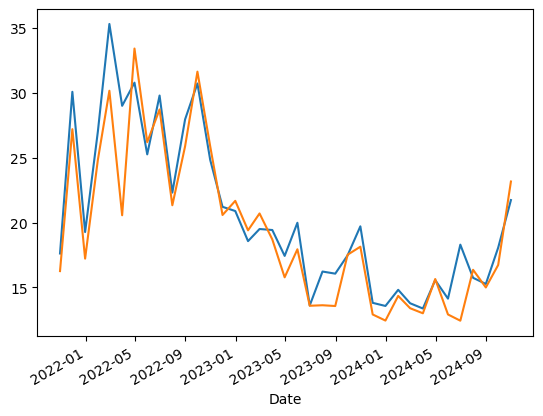

In [ ]:
maindf['EURO STOXX 50 VOLATILITY'].plot()
maindf['S&P500 VOLATILITY INDEX'].plot()
#maindf['S&P500 ret_lag_1'].plot()

<Axes: ylabel='Density'>

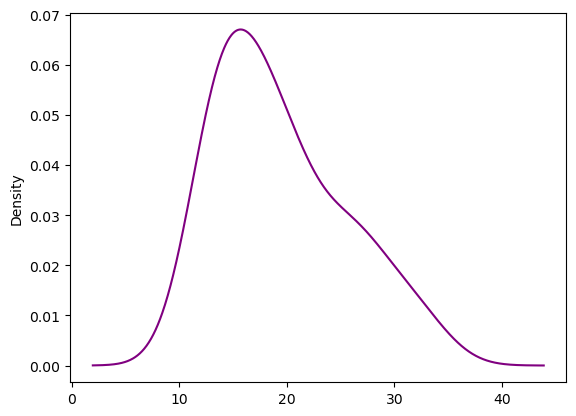

In [ ]:
#Quick kde plot
#vix['S&P500 VOLATILITY INDEX'].plot(kind='kde',color='purple')

In [ ]:
#print(maindf.dtypes)
float_df = maindf.select_dtypes(include=('float','int'))
print(float_df.dtypes)

STOXX 50 monthly_return                                     float64
STOXX 50 ret_lag1                                           float64
STOXX 50 ret_lag2                                           float64
Bloomberg_economic_surprise_index_difference                float64
Bloomberg_economic_surprise_index_difference_ret_lag1       float64
MSCI Europe_select_green_pct_change                         float64
MSCI Europe_select_green ret_lag1                           float64
NASDAQ CLEAN EDGE GREEN ENERGY_pct_change                   float64
NASDAQ CLEAN EDGE GREEN ENERGY ret_lag1                     float64
STOXX_600_energy_index_pct_change                           float64
STOXX_600_energy_index ret_lag1                             float64
ESG Index monthly_return                                    float64
ESG500_lag1                                                 float64
ecb_rate_lag1                                               float64
ecb_rate_lag2                                   

In [ ]:
correlation_matrix = float_df.corr()
print(correlation_matrix)

                                                    STOXX 50 monthly_return  \
STOXX 50 monthly_return                                            1.000000   
STOXX 50 ret_lag1                                                 -0.103340   
STOXX 50 ret_lag2                                                 -0.052144   
Bloomberg_economic_surprise_index_difference                       0.091968   
Bloomberg_economic_surprise_index_difference_re...                 0.045750   
MSCI Europe_select_green_pct_change                                0.839930   
MSCI Europe_select_green ret_lag1                                 -0.175091   
NASDAQ CLEAN EDGE GREEN ENERGY_pct_change                          0.484051   
NASDAQ CLEAN EDGE GREEN ENERGY ret_lag1                           -0.259961   
STOXX_600_energy_index_pct_change                                  0.351499   
STOXX_600_energy_index ret_lag1                                   -0.479325   
ESG Index monthly_return                            

In [ ]:
'''#Other variables preparation
final_merge = final_merge.sort_values('Date')
final_merge['S&P500_monthly_return'] = final_merge['S&P500 PX_LAST'].pct_change()

<Axes: xlabel='Date'>

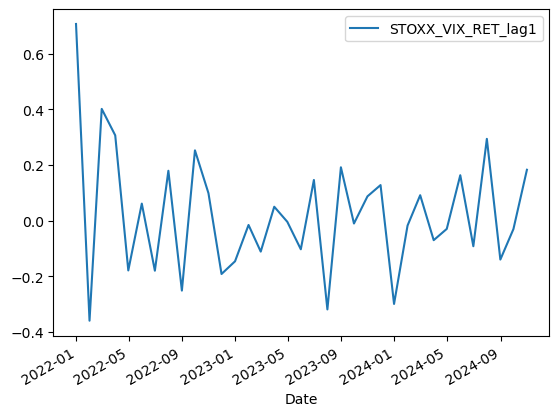

In [182]:
df_encoded.plot(x='Date',y='STOXX_VIX_RET_lag1')

Building the first model

In [185]:
month_const = {c: (df_encoded.groupby('Date')[c].nunique().max()==1) for c in X_train.columns}
# True ⇒ time-factor (same across bonds in month). False ⇒ cross-sectional feature.
print(month_const)

{'S&P500 VIX_lag_1_ret': True, 'STOXX_VIX_RET_lag1': True}


In [126]:
#Debugging NaNs
maindf['row_in_bond'] = maindf.groupby('ISIN').cumcount()
# 1 row must be dropped per bond because of pct_change(1)
maindf = maindf[maindf['row_in_bond'] >= 1].copy()

In [127]:

# Dummy columns start with these prefixes after get_dummies:D
dummy_prefixes = ['Country_'] #, 'Currency_', 'BICS Level 2'

# Extract all dummy columns automatically:
dummy_cols = [c for c in df_encoded.columns if c.startswith(tuple(dummy_prefixes))]

#numeric_cols = [,] # 
#feature_cols = numeric_cols 
#+  dummy_cols


<Axes: >

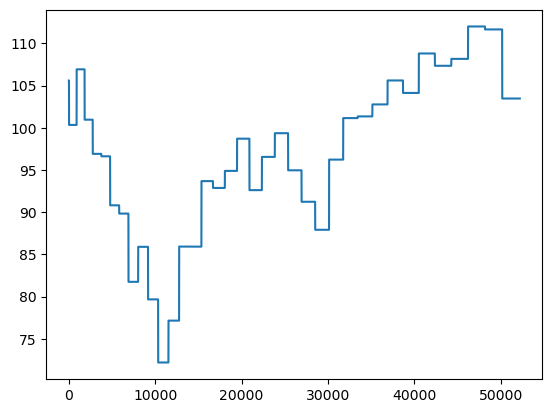

In [ ]:
#maindf['BLOOMBERG ECONOMIC SURPRISE INDEX - EUROZONE'].plot(x='Date')

In [207]:
#Macro variables
#set1_cols = ['S&P500 monthly_return','STOXX 50 monthly_return','STOXX 600 monthly_return','gold monthly_return','WTI monthly_return','BRENT monthly_return']

In [187]:
#Volatility indices
set2_cols = ['STOXX_VIX_RET_lag1'] #'S&P500 VIX_lag_1_ret'

In [387]:
#Policy rates
set3_cols =['ECB_rate_change_lag','ecb_rate_lag1','ecb_rate_lag2'] #'FED_rate_change_lag','FED_rate_lag1','FED_rate_lag2',

In [409]:
#Macro variables
set4_cols = ['STOXX 50 ret_lag1','STOXX 600 ret_lag1','gold ret_lag1', 'BRENT ret_lag1'] #'S&P500 ret_lag_1','WTI ret_lag1',

In [131]:
#Bond characteristics
set5_cols = ['duration_mid_lag1','convexity_mid_lag1','rel_spread_rank_l1',] #,'convexity_spread','duration_spread','log amount issued','years_to_mty'

In [132]:
##set6 = set1_cols +set2_cols

In [133]:
set7 = set2_cols+set3_cols


In [134]:
set8 = set2_cols+set3_cols+set4_cols

In [135]:
set9 = set2_cols+set3_cols+set4_cols+set5_cols

In [136]:
set10 = set2_cols+set4_cols

In [137]:
set11 = set2_cols+set5_cols

In [138]:
set12 = set3_cols+set4_cols

In [139]:
set13 = set3_cols+set5_cols

In [140]:
set14 = set4_cols +set5_cols

In [141]:
set15 = dummy_cols + set8

In [143]:
#Green indices
set17 = ['NASDAQ CLEAN EDGE GREEN ENERGY_pct_change','MSCI Europe_select_green_pct_change','Bloomberg_economic_surprise_index_difference','ESG Index monthly_return','STOXX_600_energy_index_pct_change']

In [389]:
#Green indices lags
set18 = ['MSCI Europe_select_green ret_lag1','Bloomberg_economic_surprise_index_difference_ret_lag1','STOXX_600_energy_index ret_lag1',] #'NASDAQ CLEAN EDGE GREEN ENERGY ret_lag1', 'ESG500_lag1',

In [233]:
set19 = set3_cols+set4_cols+set5_cols

In [145]:
set20 = set2_cols + set18

In [146]:
set21 = set2_cols + set18 +set3_cols

In [147]:
set22 = set2_cols  + set18 +set3_cols +set4_cols

In [148]:
set23 = set2_cols  + set18 +set3_cols +set4_cols +set5_cols

In [149]:
set24 =  set18 +set2_cols +set3_cols +set4_cols +set5_cols

In [373]:
set25 = set18 +set3_cols +set4_cols +set5_cols

In [314]:
set26 = set18+set3_cols

In [326]:
set27 = set18+set4_cols

In [153]:
set28 = set18+set5_cols

In [154]:
#set29 = set17 + set3_cols

In [155]:
#set30 = set17 +set4_cols

In [156]:
#set31 = set17+set5_cols

In [410]:
#defining X and y
y = df_encoded['monthly_return_pct']
X = df_encoded[set4_cols]

<Axes: ylabel='Density'>

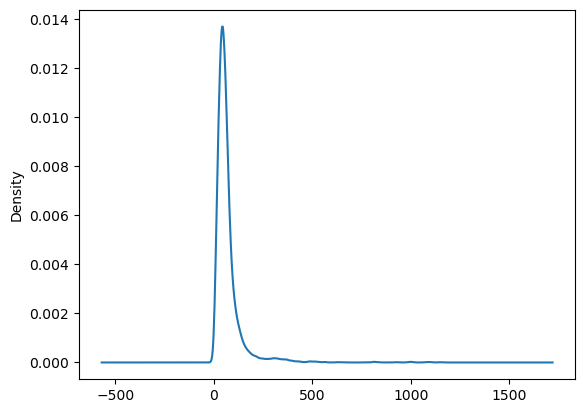

In [219]:
df_encoded['bid_ask_spread_bps'].plot(kind='density')

<Axes: >

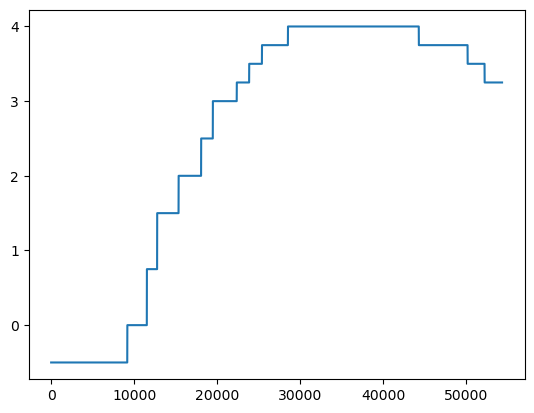

In [682]:
#Visualising data
ecb = df_encoded[['Date','ECB DEPOSIT FACILITY RATE']]
ecb = ecb.drop_duplicates('Date')
df_encoded['ECB DEPOSIT FACILITY RATE'].plot()

In [ ]:
'''#Splitting data
#maindf = maindf.sort_values(by=['Ticker','Date'])
cutoff_date = df_encoded['Date'].quantile(0.7)
train_mask = df_encoded['Date']<= cutoff_date
test_mask = df_encoded['Date'] > cutoff_date

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]


In [411]:
# encode categoricals beforehand -> df_encoded
#y = df_encoded['monthly_return'] -- NOT NEEDED EARLIER CODE ALREADY DEFINES Y

# choose/assemble your feature columns
#X = df_encoded.drop(columns=['monthly_return','Date']) -- NOT NEEDED AS EARLIER CODE ALREADY DEFINES X

# final NaN filter (y can’t have NaNs; X NaNs will be imputed in pipelines,
# but it’s cleaner to drop rows with y NaN and keep X rows aligned)
mask = y.notna()
X, y = X[mask], y[mask]

In [412]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error


def evaluate(y_true, y_pred, name="model"):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name:20s} | R²={r2:6.3f}  MAE={mae:8.5f}  RMSE={rmse:8.5f}")

In [413]:
cutoff = df_encoded.loc[mask, 'Date'].quantile(0.7)
train = df_encoded.loc[mask, 'Date'] <= cutoff
test  = df_encoded.loc[mask, 'Date'] >  cutoff

X_train, y_train = X[train], y[train]
X_test,  y_test  = X[test],  y[test]

# Baseline mean (no NaNs now)
train_mean = np.nanmean(y_train)
y_pred_mean = np.full(y_test.shape, train_mean)
evaluate(y_test, y_pred_mean, name="Baseline: train-mean")

Baseline: train-mean | R²=-0.012  MAE= 0.01046  RMSE= 0.01817


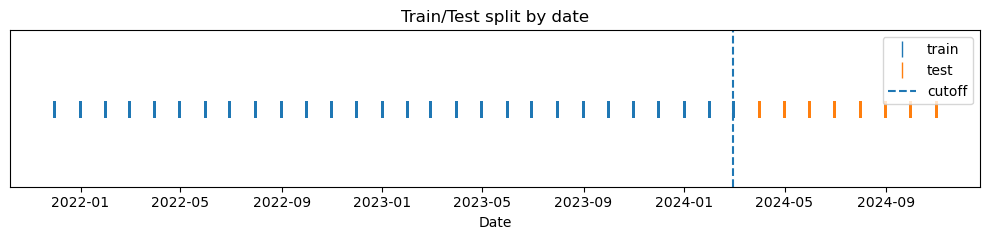

In [ ]:
#import matplotlib.pyplot as plt

# Build boolean masks once (as in your snippet)
#train = df_encoded.loc[mask, 'Date'] <= cutoff
#test  = df_encoded.loc[mask, 'Date'] >  cutoff

#dates_train = df_encoded.loc[mask].loc[train, 'Date']
#dates_test  = df_encoded.loc[mask].loc[test,  'Date']

#fig = plt.figure(figsize=(10,2.5))

# plot small vertical ticks (rug) for each set
#plt.plot(dates_train, [0]*len(dates_train), '|', markersize=12, label='train')
#plt.plot(dates_test,  [0]*len(dates_test),  '|', markersize=12, label='test')
#plt.axvline(cutoff, linestyle='--', label='cutoff')
#plt.yticks([]); plt.xlabel("Date"); plt.title("Train/Test split by date")
#plt.legend()
#plt.tight_layout()
#plt.show()

In [414]:
# Predict the train-set mean return for every test point (very hard baseline to beat in bonds)
y_pred_mean = np.full_like(y_test, fill_value=np.nan, dtype=float)
y_pred_mean[:] = np.nanmean(y_train)
evaluate(y_test, y_pred_mean, name="Baseline: train-mean")

Baseline: train-mean | R²=-0.012  MAE= 0.01046  RMSE= 0.01817


In [ ]:
'''# Time-aware CV for the internal Lasso alpha search
tscv = TimeSeriesSplit(n_splits=5)

lasso_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),    # handle any missing values
    ("scale",  StandardScaler()),                    # Lasso needs standardized features
    ("model",  LassoCV(cv=tscv, n_jobs=-1, max_iter=20000, random_state=42))
])

lasso_pipe.fit(X_train, y_train)
y_pred_lasso = lasso_pipe.predict(X_test)
evaluate(y_test, y_pred_lasso, name="LassoCV")

# Inspect non-zero coefficients (importance in a linear world)
lasso = lasso_pipe.named_steps["model"]
coef = pd.Series(lasso.coef_, index=X_train.columns).sort_values()
nonzero = coef[coef != 0]
print("\nTop +ve coefficients:\n", nonzero.tail(10))
print("\nTop -ve coefficients:\n", nonzero.head(10))
print(f"\nChosen alpha: {lasso.alpha_:.6f}")

LassoCV              | R²=-0.040  MAE= 0.01104  RMSE= 0.01826

Top +ve coefficients:
 Bloomberg_economic_surprise_index_difference   -0.001306
STOXX_600_energy_index_pct_change               0.001448
NASDAQ CLEAN EDGE GREEN ENERGY_pct_change       0.003068
MSCI Europe_select_green_pct_change             0.008234
ESG Index monthly_return                        0.009691
dtype: float64

Top -ve coefficients:
 Bloomberg_economic_surprise_index_difference   -0.001306
STOXX_600_energy_index_pct_change               0.001448
NASDAQ CLEAN EDGE GREEN ENERGY_pct_change       0.003068
MSCI Europe_select_green_pct_change             0.008234
ESG Index monthly_return                        0.009691
dtype: float64

Chosen alpha: 0.000033


In [221]:
# =========================================
# Clean two-step pipeline (stable version)
# =========================================
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --------- helpers ----------
def evaluate_true_pred(y_true, y_pred, name="Model"):
    y_true = pd.Series(y_true, dtype=float)
    y_pred = pd.Series(y_pred, dtype=float)
    m = ~y_true.isna() & ~y_pred.isna()
    if m.sum() == 0:
        print(f"{name}: no valid rows to evaluate.")
        return np.nan, np.nan, np.nan
    r2  = r2_score(y_true[m], y_pred[m])
    mae = mean_absolute_error(y_true[m], y_pred[m])
    rmse = mean_squared_error(y_true[m], y_pred[m], squared=False)
    print(f"{name:<28} | R²={r2:.3f}  MAE={mae:.5f}  RMSE={rmse:.5f}")
    return r2, mae, rmse

# --------- 0) input dataframe ----------
# expects df_encoded in memory
df = df_encoded.copy()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

target_col = 'monthly_return_pct'
assert target_col in df.columns, f"Target column '{target_col}' not found."

# Month key
df['ym'] = df['Date'].dt.to_period('M')

# --------- 1) time factor = previous month’s panel mean (leak-free) ----------
# (no modeling; very robust)
panel_mean_by_month = (df[[target_col, 'ym']]
                       .dropna(subset=[target_col])
                       .groupby('ym')[target_col].mean())
time_factor_by_month = panel_mean_by_month.shift(1)  # use prior month

df['time_pred'] = df['ym'].map(time_factor_by_month)
print("time_pred NaNs (usually first month only):", int(df['time_pred'].isna().sum()))

# --------- 2) residuals ----------
df['residual'] = pd.to_numeric(df[target_col], errors='coerce') - pd.to_numeric(df['time_pred'], errors='coerce')
print("residual NaNs (will drop from train):", int(df['residual'].isna().sum()))

# --------- 3) choose features ----------
# If you already curated a list, put it in 'set9' before running.
if 'set9' in globals() and isinstance(set9, (list, tuple)) and len(set9) > 0:
    candidate_cols = [c for c in set9 if c in df.columns]
else:
    # auto-pick numeric candidates (exclude target/time keys)
    blacklist = {target_col, 'Date', 'ym', 'time_pred', 'residual'}
    candidate_cols = [c for c in df.columns
                      if c not in blacklist and pd.api.types.is_numeric_dtype(df[c])]

# Keep only **bond-varying** features (must vary within month)
vary_within_month = []
for c in candidate_cols:
    try:
        nunq = df.groupby('ym')[c].nunique(dropna=False).max()
        vary_within_month.append(nunq > 1)
    except Exception:
        vary_within_month.append(False)
xsec_cols = [c for c, ok in zip(candidate_cols, vary_within_month) if ok]

print(f"candidate_cols: {len(candidate_cols)} | xsec_cols (vary within month): {len(xsec_cols)}")

# --------- 4) time-based split (70/30 by month) ----------
all_months = sorted(df['ym'].unique())
cut = int(0.7 * len(all_months))
train_months = set(all_months[:cut])
mask_tr = df['ym'].isin(train_months)
mask_te = ~mask_tr

# equal-weight each month in training
mcount = df.groupby('ym')['Date'].transform('size')
w = 1.0 / mcount

# restrict to rows with valid targets
fit_mask  = mask_tr & df['residual'].notna()
test_mask = mask_te & df[target_col].notna()

print(f"TRAIN rows: {int(fit_mask.sum())} | TEST rows: {int(test_mask.sum())}")

# --------- 5) build clean X/y for cross-section ----------
X_tr = df.loc[fit_mask, xsec_cols].copy()
y_tr = df.loc[fit_mask, 'residual'].astype(float)
w_tr = w.loc[fit_mask].values

# coerce to numeric
for c in X_tr.columns:
    X_tr[c] = pd.to_numeric(X_tr[c], errors='coerce')

# drop all-NaN columns and zero-variance columns in TRAIN
X_tr = X_tr.loc[:, ~X_tr.isna().all(axis=0)]
X_tr = X_tr.loc[:, X_tr.nunique(dropna=True) > 1]

if X_tr.shape[1] == 0:
    print("No usable cross-sectional features after cleaning. Using time factor only.")
    evaluate_true_pred(df.loc[test_mask, target_col], df.loc[test_mask, 'time_pred'],
                       name="Baseline (time-only)")
else:
    keep_cols = X_tr.columns.tolist()
    X_te = df.loc[test_mask, keep_cols].copy()
    for c in X_te.columns:
        X_te[c] = pd.to_numeric(X_te[c], errors='coerce')

    # --------- 6) cross-sectional model (GBM) ----------
    xsec_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("model",  GradientBoostingRegressor(
            n_estimators=400, learning_rate=0.02,
            max_depth=1, min_samples_leaf=150, min_samples_split=300,
            subsample=0.6, random_state=42
        ))
    ])

    xsec_pipe.fit(X_tr, y_tr, **{"model__sample_weight": w_tr})
    resid_pred = xsec_pipe.predict(X_te)

    y_pred_two_step = df.loc[test_mask, 'time_pred'].values + resid_pred
    evaluate_true_pred(df.loc[test_mask, target_col], y_pred_two_step,
                       name="Two-step: time(mean-1) + XSec(GBM)")

    print("\nUsed cross-sectional features:", keep_cols[:20], "..." if len(keep_cols) > 20 else "")

time_pred NaNs (usually first month only): 1811
residual NaNs (will drop from train): 3427
candidate_cols: 17 | xsec_cols (vary within month): 3
TRAIN rows: 28960 | TEST rows: 21923
Two-step: time(mean-1) + XSec(GBM): no valid rows to evaluate.

Used cross-sectional features: ['duration_mid_lag1', 'convexity_mid_lag1', 'rel_spread_rank_l1'] 


In [219]:
print("time_cols:", len(time_cols), "| xsec_cols (raw):", len(xsec_cols))
print("TRAIN rows:", mask_tr.sum(), "| TEST rows:", mask_te.sum())
print("residual NaNs in TRAIN:", df.loc[mask_tr, 'residual'].isna().sum())
print("X_tr shape after cleaning:", X_tr.shape)

time_cols: 14 | xsec_cols (raw): 3
TRAIN rows: 31762 | TEST rows: 22548


KeyError: 'residual'

In [415]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# Time-aware CV (same as Lasso)
tscv = TimeSeriesSplit(n_splits=5)

# Elastic Net pipeline
enet_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),          # handle missing
    ("scale",  StandardScaler()),                          # standardize for linear model
    ("model",  ElasticNetCV(
        l1_ratio=[0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95], # ridge<->lasso mix; CV picks the best
        cv=tscv,
        n_alphas=200,
        max_iter=20000,
        n_jobs=-1,
        random_state=42
    ))
])

# Fit & evaluate
enet_pipe.fit(X_train, y_train)
y_pred_enet = enet_pipe.predict(X_test)
evaluate(y_test, y_pred_enet, name="ElasticNetCV")

# Coefficients (in standardized feature space)
enet = enet_pipe.named_steps["model"]
coef = pd.Series(enet.coef_, index=X_train.columns).sort_values()
nonzero = coef[coef != 0]
print("\nElasticNetCV | alpha:", enet.alpha_, "| l1_ratio:", enet.l1_ratio_)
print("\nTop +ve coefficients:\n", nonzero.tail(10))
print("\nTop -ve coefficients:\n", nonzero.head(10))

ElasticNetCV         | R²=-0.012  MAE= 0.01046  RMSE= 0.01817

ElasticNetCV | alpha: 0.2252712898997289 | l1_ratio: 0.05

Top +ve coefficients:
 gold ret_lag1   -2.049593e-17
dtype: float64

Top -ve coefficients:
 gold ret_lag1   -2.049593e-17
dtype: float64


In [416]:
#Gradient boosting model
gbm = GradientBoostingRegressor(
    n_estimators=100,      # total trees -- WAS 600
    learning_rate=0.004,    # smaller lr + more trees = smoother fit -- WAS 0.3
    max_depth=1,           # shallow trees reduce overfit -- WAS 3
    subsample=0.8,         # stochastic gradient boosting
    min_samples_split=10,   # minimum samples to split
    min_samples_leaf=10,    # force leaves to have many rows
    random_state=42
)
# (Trees don’t need scaling; imputation helps)
gbm_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("model",  gbm)
])

gbm_pipe.fit(X_train, y_train)
y_pred_gbm = gbm_pipe.predict(X_test)
evaluate(y_test, y_pred_gbm, name="GradientBoosting")

# Feature importance (split-based)
imp = pd.Series(
    gbm_pipe.named_steps["model"].feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
print("\nTop GBM features:\n", imp.head(15))

GradientBoosting     | R²=-0.010  MAE= 0.01060  RMSE= 0.01816

Top GBM features:
 gold ret_lag1         0.926301
BRENT ret_lag1        0.045351
STOXX 50 ret_lag1     0.018501
STOXX 600 ret_lag1    0.009847
dtype: float64


In [419]:
y_pred_train = gbm_pipe.predict(X_train)
evaluate(y_train, y_pred_train, name="GBM Train")

GBM Train            | R²= 0.000  MAE= 0.03151  RMSE= 1.29965


In [657]:
y_pred_train = gbm.predict(X_train)
evaluate(y_train, y_pred_train, name="GBM Train")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [417]:
#Random forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=1,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)
rf_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("model",  rf)
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
evaluate(y_test, y_pred_rf, name="RandomForest")

rf_imp = pd.Series(
    rf_pipe.named_steps["model"].feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
print("\nTop RF features:\n", rf_imp.head(15))

RandomForest         | R²=-0.041  MAE= 0.01094  RMSE= 0.01843

Top RF features:
 gold ret_lag1         0.50
STOXX 600 ret_lag1    0.28
BRENT ret_lag1        0.13
STOXX 50 ret_lag1     0.09
dtype: float64


In [460]:
# SHAP is optional but great for explaining GBM predictions

try:
    import shap
    explainer = shap.Explainer(gbm_pipe.named_steps["model"])
    shap_values = explainer(X_test)  # may take time on big data
    # Summary plot (requires a notebook/plotting env)
    # shap.summary_plot(shap_values, features=X_test, feature_names=X_train.columns)
except Exception as e:
    print("SHAP not available:", e)

In [418]:
# 0) Preprocess once (same imputer you used before)
from sklearn.impute import SimpleImputer
import xgboost as xgb

imp = SimpleImputer(strategy="median").fit(X_train)
Xt_tr   = imp.transform(X_train)
Xt_test = imp.transform(X_test)

# Create a time-respecting validation split from the train set
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(Xt_tr, y_train, test_size=0.2, shuffle=False)

# 1) Build DMatrices (required by xgb.train)
dtrain = xgb.DMatrix(X_tr,  label=y_tr)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(Xt_test)

# 2) Parameters (regularized & conservative)
params = {
    "objective": "reg:squarederror",
    "eta": 0.03,                 # learning rate
    "max_depth": 1,              # shallow trees
    "min_child_weight": 20,
    "subsample": 0.5,
    "colsample_bytree": 0.6,
    "alpha": 2.0,                # L1
    "lambda": 4.0,               # L2
    "tree_method": "hist",
    "eval_metric": "rmse",
    "seed": 42,
}

# 3) Train with early stopping
watchlist = [(dtrain, "train"), (dvalid, "valid")]
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=100,
    verbose_eval=False
)

# 4) Predict on the true test set using the best iteration
y_pred_xgb = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))

# 5) Evaluate
print(evaluate(y_test, y_pred_xgb, name="XGBoost (core API)"))

# 6) Feature importance (GAIN) mapped to your column names
gain = booster.get_score(importance_type="gain")   # keys like 'f0','f1',...
feat_names = list(X_train.columns)
gain_series = pd.Series({feat_names[int(k[1:])]: v for k, v in gain.items()}) \
                .sort_values(ascending=False)
print("\nTop XGB features by GAIN:\n", gain_series.head(15))

XGBoost (core API)   | R²=-0.575  MAE= 0.01548  RMSE= 0.02268
None

Top XGB features by GAIN:
 gold ret_lag1         8.825861
STOXX 600 ret_lag1    2.618872
BRENT ret_lag1        2.591666
STOXX 50 ret_lag1     2.576484
dtype: float64


In [ ]:
#Dropping unneccesary variables
final_merge = final_merge.drop('Classification', axis=1)

In [ ]:
'''period_months = 12/ coupon_dates["CPN_FREQ"]
coupon_dates_2 = []
date_pointer = coupon_dates['Maturity']
valuation_date = coupon_dates['Date']

freq = int(row.CPN_FREQ)
period_months = int(period_months)
date_pointer = pd.to_datetime(row.Maturity)
valuation_date = pd.to_datetime(row.Date).to_period('M').to_timestamp('M')

while date_pointer > valuation_date - pd.DateOffset(years=30):
    coupon_dates_2.append(date_pointer)
    date_pointer = date_pointer - pd.DateOffset(months=period_months)

coupon_dates_2 = sorted(coupon_dates_2)'''

NameError: name 'row' is not defined

In [107]:
Extraction = ['Ticker','Amount issued','Issuer Name','Issue Date','Maturity','Cpn']

In [108]:
Extraction_1 = final_2[Extraction]

In [75]:
Extraction_1 = Extraction_1.drop_duplicates()

In [76]:
Extraction_1.to_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/SRCH_EXTRACT.csv', index=True)


In [72]:
Extraction_2 = ['Ticker']
Extraction_2_1 = final_2[Extraction_2]
Extraction_2_2 =Extraction_2_1.drop_duplicates()
Extraction_2_2.to_excel('/Users/marcohattingh/Desktop/Research Assignment/Data/ISIN_CPN_FREQ.xlsx', index=False)

In [661]:
to_drop = ['PX_ASK','PX_BID','YLD_YTM_ASK','YLD_YTM_BID', 'Ticker']
X = final_2.drop(columns= to_drop)
y = final_2['YLD_YTM_ASK']

In [662]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)  # X is your features DataFrame

In [663]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [664]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import pandas as pd

# Example dataset structure
#X = final_2.drop(columns=['Yield to Maturity'])  # Features
#y = final_2['Yield to Maturity']                # Target variable

# Split into train and test sets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer + first hidden layer
    Dense(64, activation='relu'),  # Second hidden layer
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1)                       # Output layer (linear activation for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE loss for regression

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

2025-01-15 14:40:58.817157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

In [ ]:
conda install tensorflow

In [67]:
import tensorflow as tf
print(tf.__version__)

2025-01-09 16:09:00.378945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Enhanced model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), 
          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', 
          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', 
          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dense(1)  # Output layer (linear activation for regression)
])

# Custom optimizer with lower learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.00001
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    save_best_only=True
)

# Train the model with enhanced training
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=100,  # Increased max epochs
    batch_size=32, 
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Optional: Visualization of training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

ValueError: could not convert string to float: 'Corporate Green Bond'

In [69]:
def variable_summary(df, column_name):
    print(f"Summary for '{column_name}':")
    print("Unique Values and Counts:")
    print(df[column_name].value_counts())
    print("\nSummary Statistics:")
    print(df[column_name].describe())

In [71]:
variable_summary(final_2, "Classification")

Summary for 'Classification':
Unique Values and Counts:
Classification
Corporate Green Bond    54310
Name: count, dtype: int64

Summary Statistics:
count                    54310
unique                       1
top       Corporate Green Bond
freq                     54310
Name: Classification, dtype: object


In [72]:
#drop classification
final_3 = final_2.drop(columns='Classification')